In [37]:
from keras.layers import Dense, Activation, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from random import randint
import pandas as pd
import numpy as np

### データセットの前処理
- データセットを読み込み、訓練データと予測用のデータに分割
- 正規化

In [16]:
train = pd.read_csv('./data/fashion-mnist_train.csv')
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

train_x = train_x / 255
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

### オートエンコーダーのアーキテクチャを作成
- エンコードは2000, 1200, 500の3つの層で構成されている

In [20]:
input_layer = Input(shape=(784,))

encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

latent_view = Dense(10, activation='sigmoid')(encode_layer3)

decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

output_layer = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

### モデルのアーキテクチャを可視化

In [52]:
import sys

sys.path.append('../../convnet-drawer')

In [53]:
from keras.models import Sequential
from convnet_drawer import Model, Conv2D, MaxPooling2D, Flatten, Dense

model = Model(input_shape=(28, 28, 3))

model.add(Flatten())
model.add(Dense(1500))
model.add(Dense(1000))
model.add(Dense(500))
model.add(Dense(10))
model.add(Dense(500))
model.add(Dense(1000))
model.add(Dense(1500))
model.add(Dense(784))

model.save_fig('alexnet.svg')

### モデルの概要を表示

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              1177500   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              501000    
__________

### モデルのコンパイル
- EarlyStoppingの設定

In [6]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=20, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 43s 888us/step - loss: 0.0981 - val_loss: 0.0729
Epoch 2/20
48000/48000 [==============================] - 35s 728us/step - loss: 0.0677 - val_loss: 0.0579
Epoch 3/20
48000/48000 [==============================] - 34s 699us/step - loss: 0.0504 - val_loss: 0.0426
Epoch 4/20
48000/48000 [==============================] - 44s 918us/step - loss: 0.0405 - val_loss: 0.0384
Epoch 5/20
48000/48000 [==============================] - 36s 756us/step - loss: 0.0369 - val_loss: 0.0367
Epoch 6/20
48000/48000 [==============================] - 40s 835us/step - loss: 0.0335 - val_loss: 0.0316
Epoch 7/20
48000/48000 [==============================] - 42s 883us/step - loss: 0.0306 - val_loss: 0.0290
Epoch 8/20
48000/48000 [==============================] - 39s 813us/step - loss: 0.0279 - val_loss: 0.0270
Epoch 9/20
48000/48000 [==============================] - 34s 709us/step - loss: 0.0259 - val_

### 学習モデルの可視化

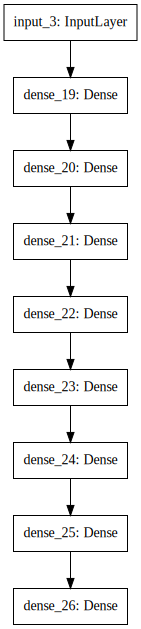

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 入力画像を表示

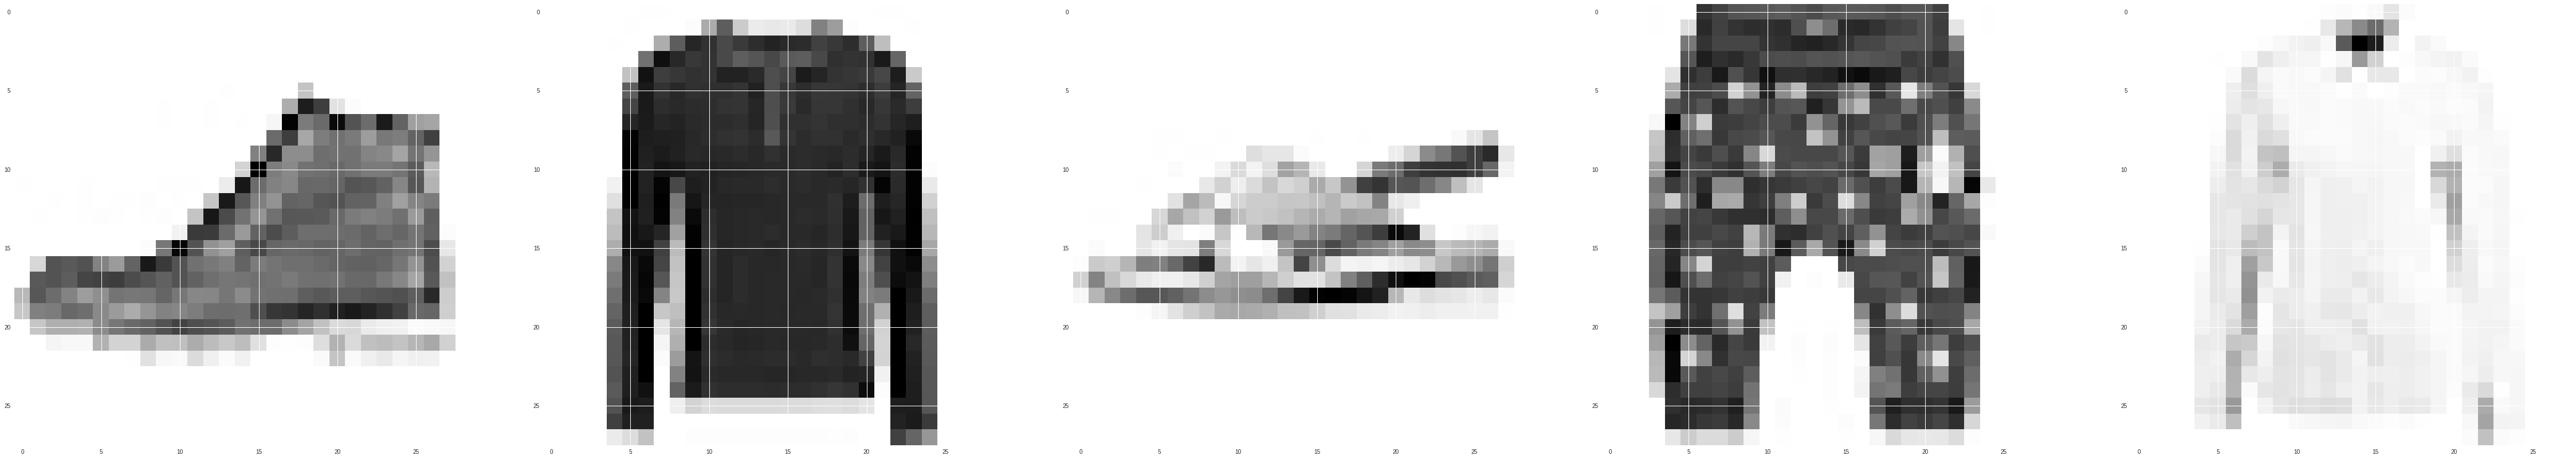

In [94]:
from PIL import Image
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5):
  ax[i].imshow(val_x[i].reshape(28, 28))
  
plt.show()

### 出力画像を表示

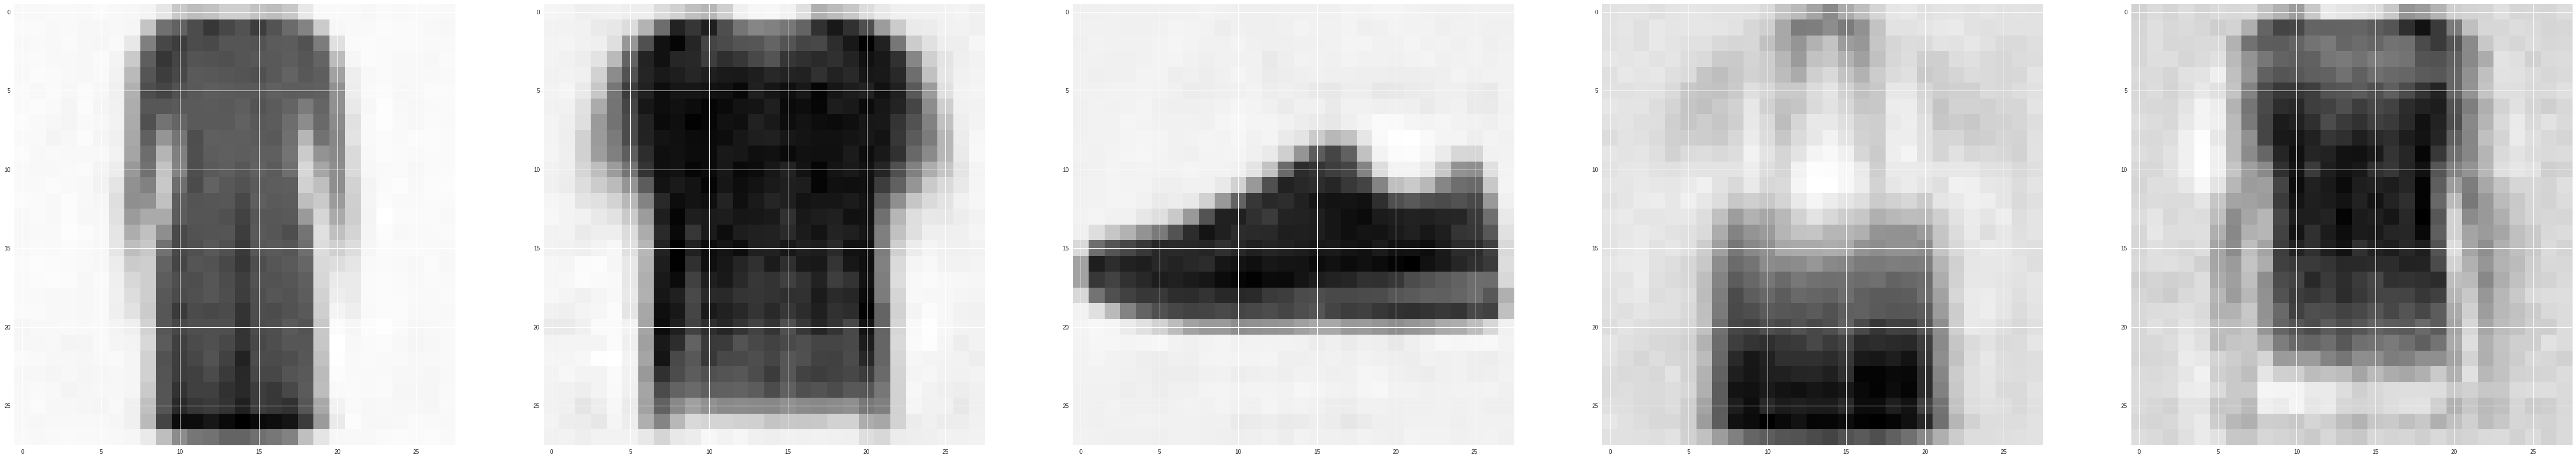

In [95]:
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5):
  ax[i].imshow(preds[i].reshape(28, 28))
  
plt.show()

### 画像のノイズ除去

In [0]:
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

In [0]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

### ノイズを付与して、画像認識の精度を上げる
- https://qiita.com/bohemian916/items/9630661cd5292240f8c7

In [0]:
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

### 加工前の画像を表示

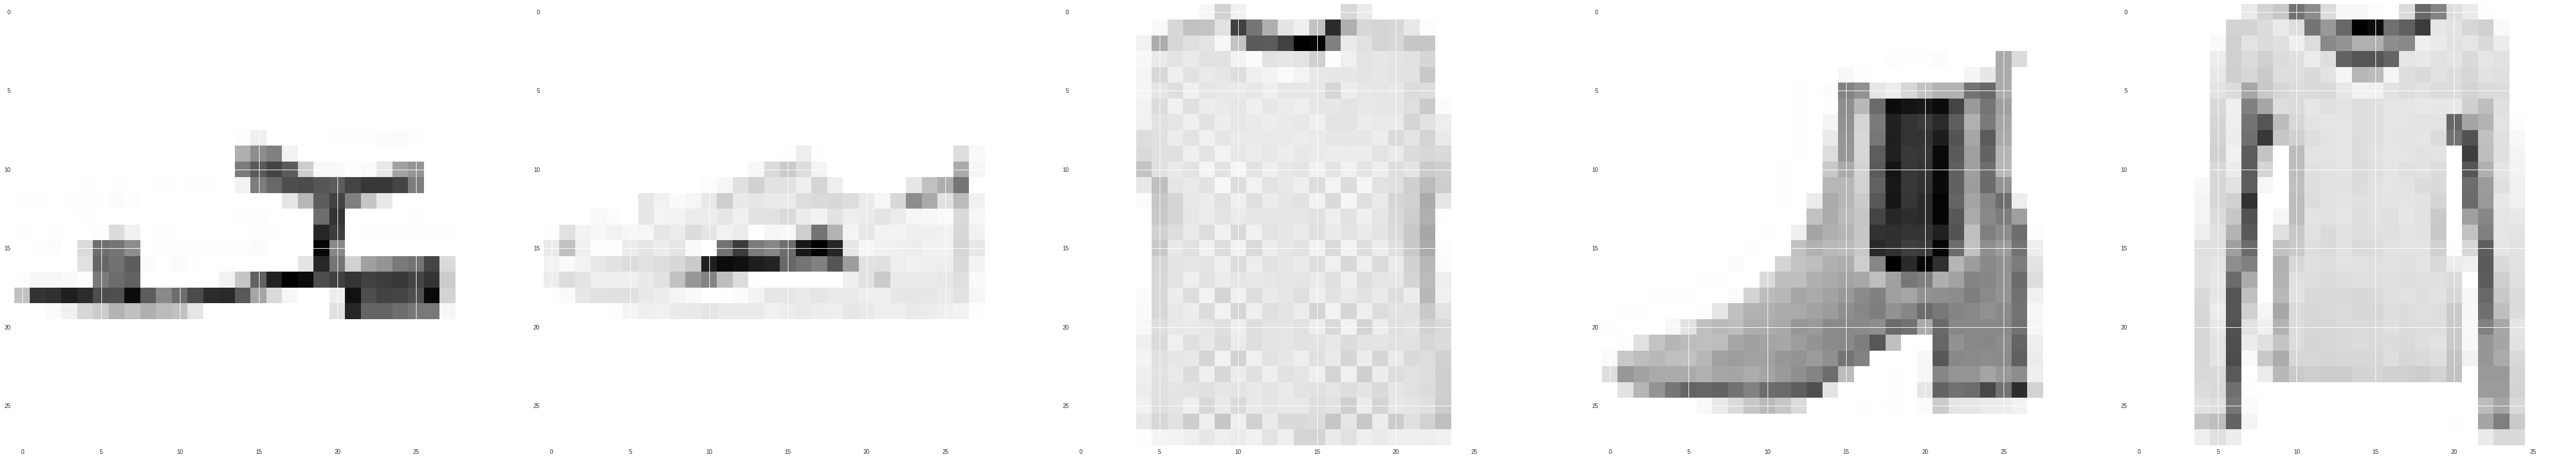

In [119]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
  ax[i-5].imshow(train_x[i].reshape(28,28))
  
plt.show()

### ノイズ付与後の画像を表示

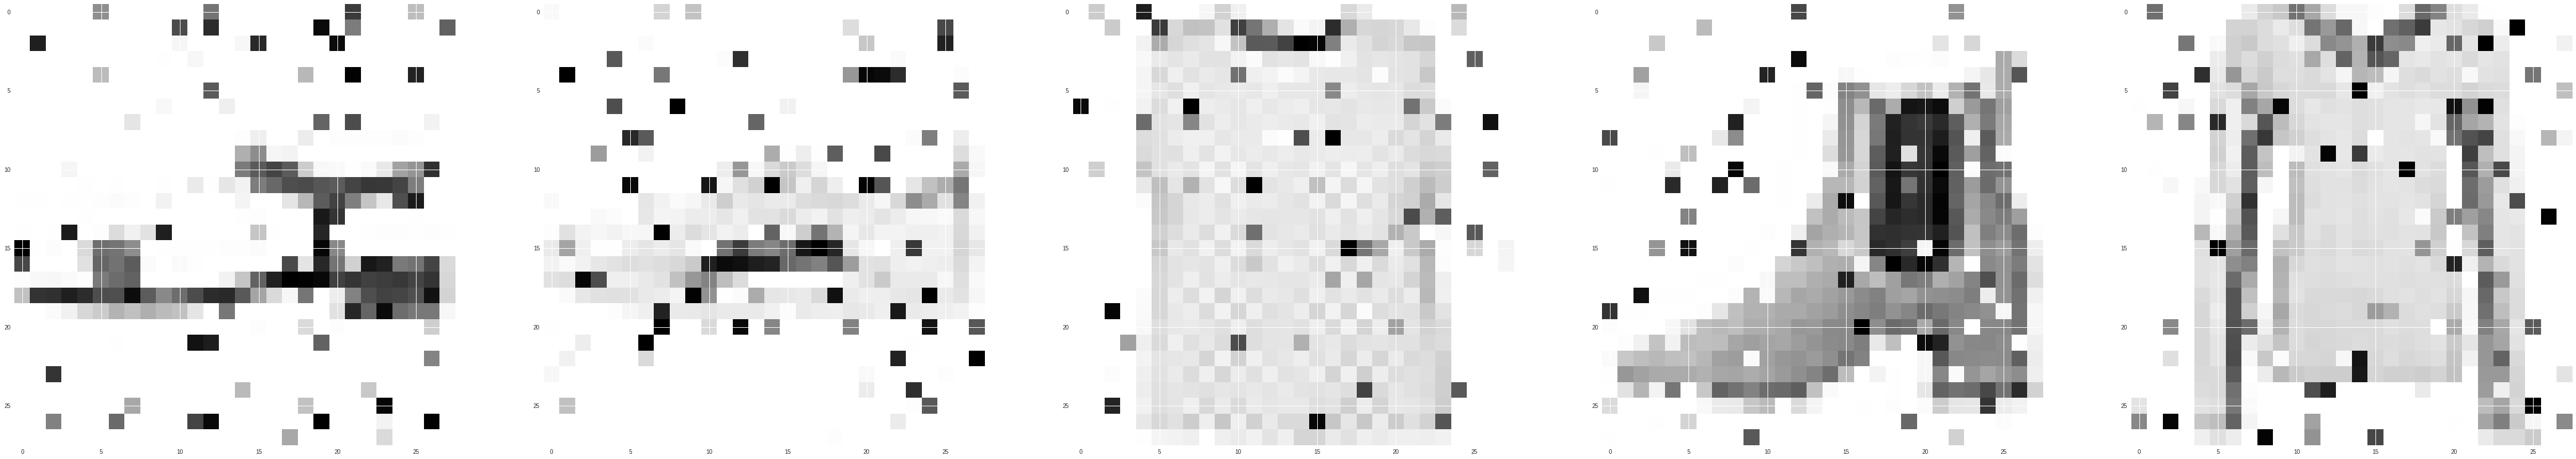

In [120]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
  ax[i-5].imshow(train_x_n[i].reshape(28,28))
  
plt.show()

### プーリング層を追加してモデル構築

In [0]:
input_layer = Input(shape=(28, 28, 1))

encoded_layer1 = Conv2D(64, (3,3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D((2,2), padding='same')(encoded_layer1)

encoded_layer2 = Conv2D(32, (3,3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D((2,2), padding='same')(encoded_layer2)

encoded_layer3 = Conv2D(16, (3,3), activation='relu', padding='same')(encoded_layer2)
latent_view = MaxPool2D((2,2), padding='same')(encoded_layer3)

decoded_layer1 = Conv2D(16, (3,3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2,2))(decoded_layer1)

decoded_layer2 = Conv2D(32, (3,3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2,2))(decoded_layer2)

decoded_layer3 = Conv2D(64, (3,3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2,2))(decoded_layer3)

output_layer = Conv2D(1, (3,3), padding='same')(decoded_layer3)

model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

### モデルの概要を表示

In [122]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 4, 4, 16)          0         
__________

### EarlyStoppingの設定

In [123]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n, train_x, epochs=10, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 251s 5ms/step - loss: 0.1117 - val_loss: 0.0614
Epoch 2/10
48000/48000 [==============================] - 247s 5ms/step - loss: 0.0500 - val_loss: 0.0409
Epoch 3/10
48000/48000 [==============================] - 248s 5ms/step - loss: 0.0357 - val_loss: 0.0319
Epoch 4/10
48000/48000 [==============================] - 247s 5ms/step - loss: 0.0298 - val_loss: 0.0278
Epoch 5/10
48000/48000 [==============================] - 247s 5ms/step - loss: 0.0265 - val_loss: 0.0253
Epoch 6/10
48000/48000 [==============================] - 248s 5ms/step - loss: 0.0245 - val_loss: 0.0237
Epoch 7/10
48000/48000 [==============================] - 247s 5ms/step - loss: 0.0233 - val_loss: 0.0226
Epoch 8/10
48000/48000 [==============================] - 247s 5ms/step - loss: 0.0222 - val_loss: 0.0217
Epoch 9/10
48000/48000 [==============================] - 249s 5ms/step - loss: 0.0215 - val_loss: 0.0

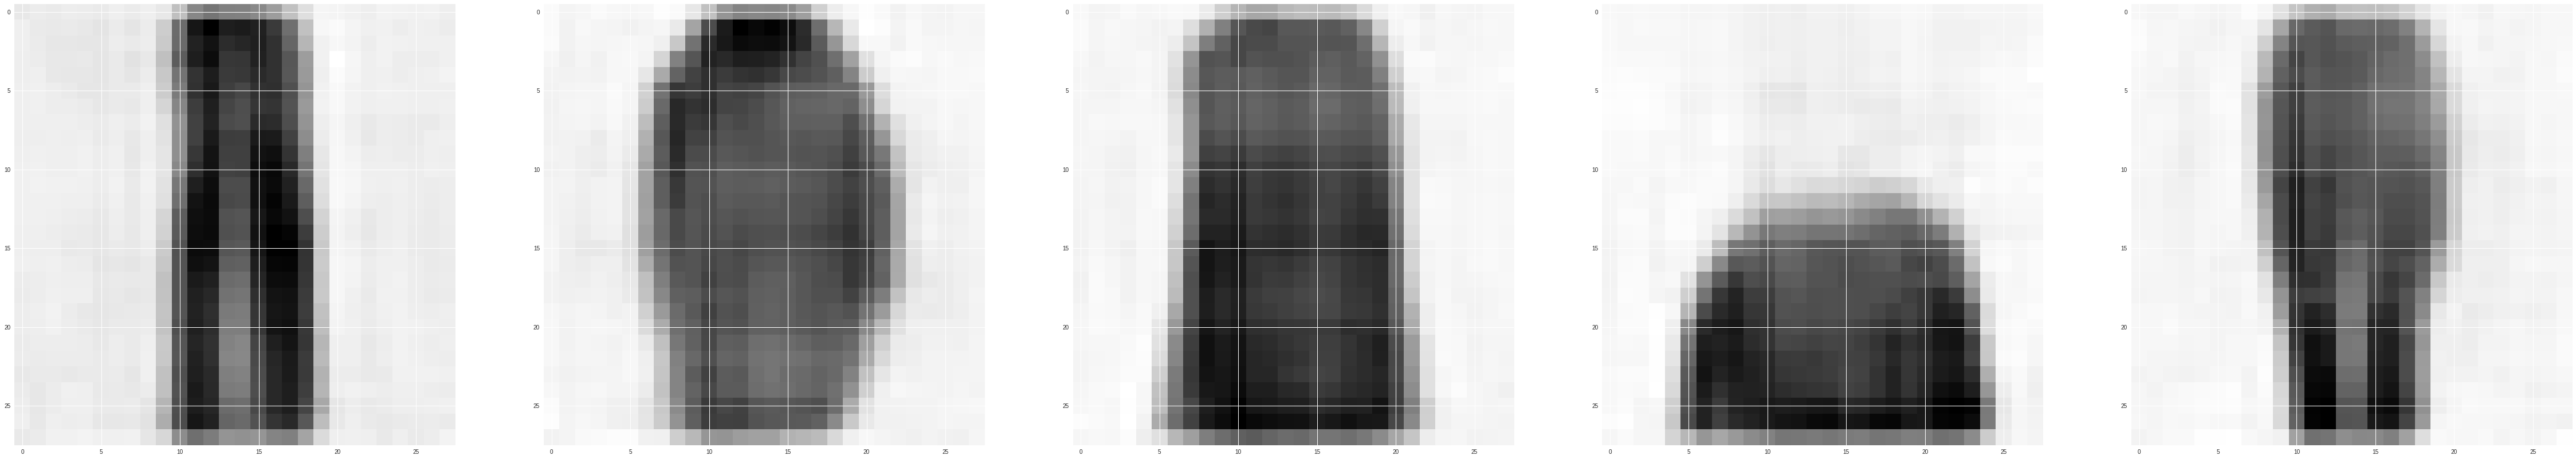

In [125]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()

### オートエンコーダを用いたシーケンス間予測

In [0]:
def dataset_preparation(n_in, n_out, n_unique, n_samples):
  X1, X2, y = [], [], []
  for _ in range(n_samples):
    inp_seq = [randint(1, n_unique-1) for _ in range(n_in)]
    
    target_seq = list(reversed(target))
    send_seq = [0] + target_seq[:-1]
    
    X1.append(to_categorical([inp_seq], num_classes=n_unique))
    X2.append(to_categorical([seed_seq], num_classes=n_unique))
    y.append(to_categorical([target_seq], num_classes=n_unique))
    
    X1 = np.squeeze(np.array(X1), axis=1)
    X2 = np.squeeze(np.array(X2), axis=1)
    y = np.squeeze(np.array(y), axis=1)
    
    return X1, X2, y
  
  samples = 100000
  features = 51
  inp_size = 6
  out_size = 3
  
  inputs, seeds, outputs = dataset_preparation(inp_size, out_size, features, samples)
  
  print("Shapes: ", inputs.shape, seeds.shape, outputs.shape)
  print("Here is first categorically encoded input seqquence looks like: ",)
  inputs[0][0]